# Content-based recommender system

## Europe Top 10 Attractions

### This notebook uses the EuropeTop100Attractions_ENG_20190101_20210821 dataset
Content-based recommendations systems recommend atractions that are similar to atractions previously visited by other customers. The models used in content-based recommender systems identify common features across user preferences based on the historical choices data of the user.

Develop a system to recommend attractions that similar users visited. For example, based on previous visits from all users, recommend an attraction to go together with a another attraction.


In [1]:
# Packages
import os
import numpy as np
import pandas as pd
import openpyxl
import re
from sklearn.metrics import pairwise 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Distances functions
from sklearn.metrics import pairwise_distances

In [3]:
# Global definitions
baseFolder = os.getcwd()
exportsFolder = baseFolder + os.sep +'Exports' + os.sep

In [4]:
subPlots_Title_fontSize = 12
subPlots_xAxis_fontSize = 10
subPlots_yAxis_fontSize = 10
subPlots_label_fontSize = 10
heatmaps_text_fontSize = 8

plots_Title_fontSize = 14
plots_Title_textColour = 'black'

plots_Legend_fontSize = 12
plots_Legend_textColour = 'black'

In [5]:
# Load data 
ds = pd.read_excel('EuropeTop100Attractions_ENG_20190101_20210821.xlsx', engine='openpyxl')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92120 entries, 0 to 92119
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            92120 non-null  object        
 1   extractionDate     92120 non-null  datetime64[ns]
 2   globalRating       92120 non-null  float64       
 3   positionOnRanking  92120 non-null  int64         
 4   sitesOnRanking     92120 non-null  int64         
 5   totalReviews       92120 non-null  int64         
 6   userName           92100 non-null  object        
 7   userLocation       78652 non-null  object        
 8   userContributions  92120 non-null  int64         
 9   tripType           63052 non-null  object        
 10  reviewWritten      92120 non-null  datetime64[ns]
 11  reviewVisited      91410 non-null  datetime64[ns]
 12  reviewRating       92120 non-null  int64         
 13  reviewLanguage     92120 non-null  object        
 14  review

In [6]:
# Reformat variable types
cols = ['localID','userName','userLocation','tripType','reviewLanguage','reviewFullText']
ds[cols] = ds[cols].astype(str)

In [7]:
# Summary statistics for all variables
ds.describe(include='all', datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
localID,92120,100,MAG001,8309,NaN,NaN,NaN,NaN,NaN,NaN,NaN
extractionDate,92120,NaN,NaN,NaN,2021-08-20 22:09:20.598932992,2021-08-20 08:24:40.077000,2021-08-20 12:08:10.831000064,2021-08-20 15:46:58.171000064,2021-08-21 12:35:39.817250048,2021-08-21 16:27:17.026000,NaN
globalRating,92120.0,NaN,NaN,NaN,4.485166,4.0,4.5,4.5,4.5,5.0,0.178085
positionOnRanking,92120.0,NaN,NaN,NaN,3.91459,1.0,1.0,2.0,6.0,55.0,4.843013
sitesOnRanking,92120.0,NaN,NaN,NaN,748.263537,5.0,154.0,484.0,1186.0,3837.0,802.742304
totalReviews,92120.0,NaN,NaN,NaN,40556.601813,5179.0,14152.0,24454.0,51324.0,163828.0,42914.381014
userName,92120,65786,Malgorzata@Margo7850p,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userLocation,92120,12614,nan,13468,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userContributions,92120.0,NaN,NaN,NaN,477.52056,0.0,20.0,66.0,215.0,607732.0,7270.518677
tripType,92120,6,Couples,31702,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Check products cardinality
usernameCount = ds['userName'].value_counts()
usernameCount

Malgorzata@Margo7850p                    31
KodoDrummer@KodoDrummer                  24
nan                                      20
Michele Amico🇮🇹🇮🇹🇮🇹🇮🇹@micheleaQ8239JH    19
Dimitris L@750dimitrisl                  17
                                         ..
Mogoshadi S@mogoshadis                    1
Crystal Chris@CrystalPistol007            1
Grantley@GrantleyMorgan                   1
Burnsfun@Burnsfun                         1
czlido@czlido                             1
Name: userName, Length: 65786, dtype: int64

In [9]:
# Check products cardinality
userlocationCount = ds['userLocation'].value_counts()
userlocationCount

nan                        13468
London, UK                  3710
Melbourne, Australia         773
Sydney, Australia            736
New York City, NY            699
                           ...  
Teresopolis, RJ                1
Pittsworth, Australia          1
Scone, Australia               1
Berea, OH                      1
Elburg, The Netherlands        1
Name: userLocation, Length: 12614, dtype: int64

In [10]:
# Check products cardinality
tripTypeCount = ds['tripType'].value_counts()
tripTypeCount

Couples     31702
nan         29068
Family      13596
Friends     11759
Solo         5127
Business      868
Name: tripType, dtype: int64

## Data Preparation

In [11]:
#identify duplicate rows
duplicateRows = ds[ds.duplicated()]

In [12]:
#view duplicate rows
duplicateRows

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText


In [13]:
## figuring out if we can remove the outliers
ds['positionOnRanking'].value_counts()

1     38547
2     12821
3     11549
7      7026
8      5668
11     2885
4      2834
10     2362
6      2282
5      2223
12     1097
24      806
9       710
31      595
16      312
19      243
55      160
Name: positionOnRanking, dtype: int64

In [14]:
# removing rows from position on ranking 
ds =ds[ds['positionOnRanking']<=12]

In [15]:
ds['positionOnRanking'].value_counts()

1     38547
2     12821
3     11549
7      7026
8      5668
11     2885
4      2834
10     2362
6      2282
5      2223
12     1097
9       710
Name: positionOnRanking, dtype: int64

In [16]:
# checking for missing data,  creating bool series for missing data
bool_series = pd.isnull(ds['userLocation'])

In [17]:
# filtering data
# displaying data only with location = NaN
ds[bool_series]

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText


In [18]:
#Use the modal value to replace missing data in userLocation
ds['userLocation'].replace([np.nan], ds['userLocation'].mode()[0], inplace=True)
print(ds)

      localID          extractionDate  globalRating  positionOnRanking  \
0      MAG001 2021-08-20 08:24:40.077           4.5                  1   
1      MAG001 2021-08-20 08:24:40.097           4.5                  1   
2      MAG001 2021-08-20 08:24:40.117           4.5                  1   
3      MAG001 2021-08-20 08:24:40.147           4.5                  1   
4      MAG001 2021-08-20 08:24:40.159           4.5                  1   
...       ...                     ...           ...                ...   
92115  MAG100 2021-08-21 16:27:11.795           4.5                 11   
92116  MAG100 2021-08-21 16:27:11.893           4.5                 11   
92117  MAG100 2021-08-21 16:27:11.993           4.5                 11   
92118  MAG100 2021-08-21 16:27:12.086           4.5                 11   
92119  MAG100 2021-08-21 16:27:17.026           4.5                 11   

       sitesOnRanking  totalReviews                   userName  \
0                1186        163828      Maur

In [19]:
# display data where location previously = NaN
ds[bool_series]

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText


In [20]:
# checking for missing data review visited,  creating bool series for missing data
dv_series = pd.isnull(ds['reviewVisited'])

In [21]:
ds[dv_series]

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText
78,MAG001,2021-08-20 08:25:18.941,4.5,1,1186,163828,thomas@thomasphunos,"Manchester, UK",1,nan,2020-09-25,NaT,4,en,"Amazing place , now a days it was not very qui..."
624,MAG001,2021-08-20 08:30:40.273,4.5,1,1186,163828,Paolo616616@Paolo616616,"Prague, Czech Republic",284,nan,2020-02-03,NaT,5,en,"Beautiful unfinished building, should be compl..."
841,MAG001,2021-08-20 08:33:01.027,4.5,1,1186,163828,StevenK@stevenkoh9999,"Singapore, Singapore",172,nan,2020-01-08,NaT,5,en,A lifetime of designing and planning by the ar...
850,MAG001,2021-08-20 08:33:06.518,4.5,1,1186,163828,Margarita@Margaritano,Europe,18,nan,2020-01-07,NaT,4,en,Everybody suggest Sagrada Familia. I loved the...
3183,MAG001,2021-08-20 08:55:30.759,4.5,1,1186,163828,Andrew Jones@wigan1969,nan,2,nan,2019-09-05,NaT,1,en,"Nice to look at from the outside, however I ha..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89332,MAG087,2021-08-21 15:58:48.146,4.0,1,5,6182,Jo P@I4996RBjoannap,"Brough, UK",343,nan,2019-07-31,NaT,5,en,Plenty to walk around and see and you can walk...
89338,MAG087,2021-08-21 15:58:48.682,4.0,1,5,6182,GMcC73@GMcC73,"Cork, Ireland",36,nan,2019-07-28,NaT,4,en,We spent a really enjoyable 4 hours there with...
89339,MAG087,2021-08-21 15:58:48.774,4.0,1,5,6182,CWXXXJH@CWXXXJH,"Berkhamsted, UK",46,nan,2019-07-22,NaT,5,en,Well worth signing up for one of the twice dai...
89347,MAG087,2021-08-21 15:58:54.396,4.0,1,5,6182,Lala L@LalaL827,"Alrewas, UK",87,nan,2019-07-10,NaT,3,en,"I cycled here in the morning, came off the mai..."


In [22]:
#Use the modal value to replace missing data in reviewvisited
ds['reviewVisited'].replace([np.nan], ds['reviewVisited'].mode()[0], inplace=True)

In [23]:
ds[dv_series]

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText
78,MAG001,2021-08-20 08:25:18.941,4.5,1,1186,163828,thomas@thomasphunos,"Manchester, UK",1,nan,2020-09-25,2019-09-01,4,en,"Amazing place , now a days it was not very qui..."
624,MAG001,2021-08-20 08:30:40.273,4.5,1,1186,163828,Paolo616616@Paolo616616,"Prague, Czech Republic",284,nan,2020-02-03,2019-09-01,5,en,"Beautiful unfinished building, should be compl..."
841,MAG001,2021-08-20 08:33:01.027,4.5,1,1186,163828,StevenK@stevenkoh9999,"Singapore, Singapore",172,nan,2020-01-08,2019-09-01,5,en,A lifetime of designing and planning by the ar...
850,MAG001,2021-08-20 08:33:06.518,4.5,1,1186,163828,Margarita@Margaritano,Europe,18,nan,2020-01-07,2019-09-01,4,en,Everybody suggest Sagrada Familia. I loved the...
3183,MAG001,2021-08-20 08:55:30.759,4.5,1,1186,163828,Andrew Jones@wigan1969,nan,2,nan,2019-09-05,2019-09-01,1,en,"Nice to look at from the outside, however I ha..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89332,MAG087,2021-08-21 15:58:48.146,4.0,1,5,6182,Jo P@I4996RBjoannap,"Brough, UK",343,nan,2019-07-31,2019-09-01,5,en,Plenty to walk around and see and you can walk...
89338,MAG087,2021-08-21 15:58:48.682,4.0,1,5,6182,GMcC73@GMcC73,"Cork, Ireland",36,nan,2019-07-28,2019-09-01,4,en,We spent a really enjoyable 4 hours there with...
89339,MAG087,2021-08-21 15:58:48.774,4.0,1,5,6182,CWXXXJH@CWXXXJH,"Berkhamsted, UK",46,nan,2019-07-22,2019-09-01,5,en,Well worth signing up for one of the twice dai...
89347,MAG087,2021-08-21 15:58:54.396,4.0,1,5,6182,Lala L@LalaL827,"Alrewas, UK",87,nan,2019-07-10,2019-09-01,3,en,"I cycled here in the morning, came off the mai..."


In [24]:
# checking for missing data for trip type,  creating bool series for missing data
tt_series = pd.isnull(ds['tripType'])

In [25]:
ds[tt_series]

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText


In [26]:
#Use 'Other' value to replace missing data in triptype
ds['tripType'].fillna(value = 'Other', inplace = True)

In [27]:
ds[tt_series]

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText


In [28]:
# Loading the Table Attraction and combine

In [29]:
ds_att = pd.read_excel(io = 'EuropeTop100Attractions_ENG_20190101_20210821.xlsx', sheet_name= 'Attractions',engine= 'openpyxl')
ds_att

,ID,Name,Country,ISO
0,MAG001,Basilica of the Sagrada Familia,Spain,ES
1,MAG002,Parc Guell,Spain,ES
2,MAG003,Tower of London,England,UK
3,MAG004,Casa Batllo,Spain,ES
4,MAG005,Staromestske namesti,Czech Republic,CZ
...,...,...,...,...
95,MAG096,Duomo di Pisa,Italy,IT
96,MAG097,La Lonja de la Seda,Spain,ES
97,MAG098,The Walls of Avila,Spain,ES
98,MAG099,Place Stanislas,France,FR


In [30]:
ds_att.columns

Index(['ID', 'Name', 'Country', 'ISO'], dtype='object')

In [31]:
ds_att.columns = ['localID', 'Name', 'Country', 'ISO']
ds_att.columns

Index(['localID', 'Name', 'Country', 'ISO'], dtype='object')

In [32]:
ds_com = ds.merge(ds_att, how='left', on='localID')
ds_com.head()

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText,Name,Country,ISO
0,MAG001,2021-08-20 08:24:40.077,4.5,1,1186,163828,Maurice M@MauriceM171,"Indianapolis, IN",29,Couples,2021-08-18,2021-08-01,5,en,"Absolutely breathtaking use of light, an amazi...",Basilica of the Sagrada Familia,Spain,ES
1,MAG001,2021-08-20 08:24:40.097,4.5,1,1186,163828,nickchamb@nickchamb,"Bandon, Ireland",7,Couples,2021-08-17,2021-03-01,5,en,A really interesting and beautiful place to vi...,Basilica of the Sagrada Familia,Spain,ES
2,MAG001,2021-08-20 08:24:40.117,4.5,1,1186,163828,Arthur Villon@arthur4588,"Valencia, Spain",268,Friends,2021-08-16,2021-08-01,5,en,Beautiful place and must visit place in barcel...,Basilica of the Sagrada Familia,Spain,ES
3,MAG001,2021-08-20 08:24:40.147,4.5,1,1186,163828,James U@696jamesu,nan,7,nan,2021-08-16,2021-07-01,5,en,A MUST when visiting Barcelkona. It is consta...,Basilica of the Sagrada Familia,Spain,ES
4,MAG001,2021-08-20 08:24:40.159,4.5,1,1186,163828,Kamal K Sirra@Sirra63,"Madrid, Spain",516,Family,2021-08-15,2021-07-01,4,en,I visited about 20 years ago and there has bee...,Basilica of the Sagrada Familia,Spain,ES


In [33]:
# Reformat variable types
cols = ['Country']
ds_com[cols] = ds_com[cols].astype(str)

In [34]:
ds_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90004 entries, 0 to 90003
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            90004 non-null  object        
 1   extractionDate     90004 non-null  datetime64[ns]
 2   globalRating       90004 non-null  float64       
 3   positionOnRanking  90004 non-null  int64         
 4   sitesOnRanking     90004 non-null  int64         
 5   totalReviews       90004 non-null  int64         
 6   userName           90004 non-null  object        
 7   userLocation       90004 non-null  object        
 8   userContributions  90004 non-null  int64         
 9   tripType           90004 non-null  object        
 10  reviewWritten      90004 non-null  datetime64[ns]
 11  reviewVisited      90004 non-null  datetime64[ns]
 12  reviewRating       90004 non-null  int64         
 13  reviewLanguage     90004 non-null  object        
 14  review

In [35]:
# Reformat variable types
cols = ['userName']
ds_com[cols] = ds_com[cols].astype(str)
ds_com.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90004 entries, 0 to 90003
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            90004 non-null  object        
 1   extractionDate     90004 non-null  datetime64[ns]
 2   globalRating       90004 non-null  float64       
 3   positionOnRanking  90004 non-null  int64         
 4   sitesOnRanking     90004 non-null  int64         
 5   totalReviews       90004 non-null  int64         
 6   userName           90004 non-null  object        
 7   userLocation       90004 non-null  object        
 8   userContributions  90004 non-null  int64         
 9   tripType           90004 non-null  object        
 10  reviewWritten      90004 non-null  datetime64[ns]
 11  reviewVisited      90004 non-null  datetime64[ns]
 12  reviewRating       90004 non-null  int64         
 13  reviewLanguage     90004 non-null  object        
 14  review

In [36]:
df = pd.DataFrame(ds_com)
# Filter the DataFrame to only include rows where the "Country" column is not equal to "Portugal"
filtered_df = df[df['Country'] !='Portugal']
# drop the rows
df.drop(filtered_df.index, inplace=True)
df

,localID,extractionDate,globalRating,positionOnRanking,sitesOnRanking,totalReviews,userName,userLocation,userContributions,tripType,reviewWritten,reviewVisited,reviewRating,reviewLanguage,reviewFullText,Name,Country,ISO
29827,MAG010,2021-08-20 13:10:44.095,4.0,6,726,36979,Barbs25@Barbs25,"Staffordshire, UK",2273,Friends,2021-08-11,2021-07-01,3,en,Not blown away by it but nice enough to look a...,Torre de Belém,Portugal,PT
29828,MAG010,2021-08-20 13:10:44.126,4.0,6,726,36979,WWH47@WWH47,"Baton Rouge, LA",121,nan,2021-08-02,2021-07-01,5,en,Well worth the visit in the Belem portion of t...,Torre de Belém,Portugal,PT
29829,MAG010,2021-08-20 13:10:44.173,4.0,6,726,36979,Runawayblond@runawayblond,"Chicago, IL",217,Solo,2021-07-26,2021-06-01,4,en,Really cool! Sadly it was closed to explore be...,Torre de Belém,Portugal,PT
29830,MAG010,2021-08-20 13:10:44.204,4.0,6,726,36979,Darren H@DarrenHumphrey,"Orlando, FL",298,nan,2021-07-24,2021-06-01,5,en,What visit to Lisbon is complete without at le...,Torre de Belém,Portugal,PT
29831,MAG010,2021-08-20 13:10:44.257,4.0,6,726,36979,Kevin S@kevins684,"Pontypridd, UK",4550,nan,2021-07-23,2021-07-01,4,en,"A 16th century tower, ornately built so seemin...",Torre de Belém,Portugal,PT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89051,MAG093,2021-08-21 16:16:09.740,4.5,1,101,6805,JAFL@Joao-Jafl,"Braga, Portugal",17,Solo,2019-02-12,2019-01-01,5,en,Excelente place for walk or running with amazi...,Bom Jesus do Monte,Portugal,PT
89052,MAG093,2021-08-21 16:16:09.846,4.5,1,101,6805,Loveitta@Loveitta,"Manchester, UK",24,Solo,2019-01-17,2019-01-01,5,en,I'm so happy that i visited this amazing churc...,Bom Jesus do Monte,Portugal,PT
89053,MAG093,2021-08-21 16:16:09.952,4.5,1,101,6805,Kaytd60@Kaytd60,"Adelaide, Australia",33,nan,2019-01-15,2018-09-01,5,en,We took the local bus up to Bom Jesus do Monte...,Bom Jesus do Monte,Portugal,PT
89054,MAG093,2021-08-21 16:16:10.049,4.5,1,101,6805,BlueSkyTravell@BlueSkyTravell,"Obertshausen, Germany",18,Family,2019-01-03,2019-01-01,5,en,Great place and fantastic views.If you come wi...,Bom Jesus do Monte,Portugal,PT


In [37]:
df.describe(include='all',datetime_is_numeric=True).T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
localID,5559,7,MAG010,1397,NaN,NaN,NaN,NaN,NaN,NaN,NaN
extractionDate,5559,NaN,NaN,NaN,2021-08-20 22:26:44.362572800,2021-08-20 13:10:44.095000,2021-08-20 13:24:45.713499904,2021-08-20 15:45:21.684000,2021-08-21 10:30:06.986999808,2021-08-21 16:16:10.145000,NaN
globalRating,5559.0,NaN,NaN,NaN,4.427865,4.0,4.0,4.5,4.5,5.0,0.29051
positionOnRanking,5559.0,NaN,NaN,NaN,2.953589,1.0,1.0,3.0,6.0,6.0,1.918266
sitesOnRanking,5559.0,NaN,NaN,NaN,434.540025,71.0,71.0,355.0,726.0,726.0,285.211268
totalReviews,5559.0,NaN,NaN,NaN,25336.923188,6805.0,18392.0,24454.0,36979.0,36979.0,9246.44892
userName,5559,3957,DianeER@DianeER,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userLocation,5559,1694,nan,682,NaN,NaN,NaN,NaN,NaN,NaN,NaN
userContributions,5559.0,NaN,NaN,NaN,677.842777,1.0,28.0,97.0,308.0,165905.0,5228.399822
tripType,5559,6,Couples,2099,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#Check Name Attraction cordinality
Nameattcount = df['Name'].value_counts()
Nameattcount

Torre de Belém                      1397
Mosteiro dos Jeronimos              1130
Park and National Palace of Pena    1007
Ponte de Dom Luís I                  967
Quinta da Regaleira                  595
Cais da Ribeira                      304
Bom Jesus do Monte                   159
Name: Name, dtype: int64

In [39]:
#Check Country Attraction cordinality
Countryattcount = df['Country'].value_counts()
Countryattcount

Portugal    5559
Name: Country, dtype: int64

In [40]:
### Customer-item matrix
NameattuserNameMatrix = df.pivot_table(
                    index='userName',
                    columns='Name',
                    values='reviewRating',
                    aggfunc=lambda x: 1 if len(x)>0 else 0).fillna(0)

In [41]:
NameattuserNameMatrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3957 entries, 007JNR@007JNR to 桂子 大@_T2961PL
Data columns (total 7 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Bom Jesus do Monte                3957 non-null   float64
 1   Cais da Ribeira                   3957 non-null   float64
 2   Mosteiro dos Jeronimos            3957 non-null   float64
 3   Park and National Palace of Pena  3957 non-null   float64
 4   Ponte de Dom Luís I               3957 non-null   float64
 5   Quinta da Regaleira               3957 non-null   float64
 6   Torre de Belém                    3957 non-null   float64
dtypes: float64(7)
memory usage: 247.3+ KB


In [42]:
# See matrix for one specific attraction
NameattuserNameMatrix.head()

Name,Bom Jesus do Monte,Cais da Ribeira,Mosteiro dos Jeronimos,Park and National Palace of Pena,Ponte de Dom Luís I,Quinta da Regaleira,Torre de Belém
userName,,,,,,,
007JNR@007JNR,0.0,0.0,0.0,0.0,0.0,0.0,1.0
0Garza@0Garza,0.0,0.0,1.0,1.0,0.0,0.0,1.0
101eggie@101eggie,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1104@1104,0.0,0.0,1.0,0.0,0.0,0.0,0.0
110Helen2014@110Helen2014,0.0,0.0,1.0,0.0,0.0,0.0,0.0


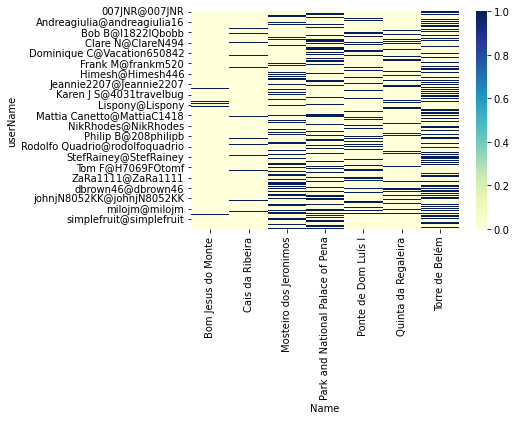

In [43]:
sns.heatmap(NameattuserNameMatrix, cmap='YlGnBu')
plt.show()

In [44]:
# Shape of the matrix
NameattuserNameMatrix.shape

(3957, 7)

## Customer based recommendations
 ### Based on similar costumers' attractions visits

In [45]:
# Create a customer to customer similarity matrix
# Info on the "cosine" implementation https://docs.scipy.org/doc/scipy/reference/reference/generated/scipy.spatial.distance.cosine.html#scipy.spatial.distance.cosine
userName_userName_sim_matrix = pd.DataFrame(
    pairwise_distances(NameattuserNameMatrix,metric='cosine'),
    columns = NameattuserNameMatrix.index,
    index = NameattuserNameMatrix.index
)
userName_userName_sim_matrix = userName_userName_sim_matrix.apply(lambda x: 1-x, axis=1) # Transform dissimilarity to similarity
userName_userName_sim_matrix

userName,007JNR@007JNR,0Garza@0Garza,101eggie@101eggie,1104@1104,110Helen2014@110Helen2014,110randn@110randn,1234texas@1234texas,13playaazul@13playaazul,1527holiday1011@1527holiday1011,157nk@157nk,...,zoeh198@zoeh198,zubenel57@zubenel57,zuni P@zunip,zylig@zylig,Ανδρόνικος Γκιουμές@T1025ZU_,Екатерина Г@_C5261QZ,Олександр П@X5628EZ_,Симеон Б@FrequentFlier415125,יוסי מ@K454TO_,桂子 大@_T2961PL
userName,,,,,,,,,,,,,,,,,,,,,
007JNR@007JNR,1.000000,0.577350,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.0,0.707107,0.00000,0.000000,1.000000
0Garza@0Garza,0.577350,1.000000,0.57735,0.577350,0.577350,0.0,0.00000,0.577350,0.408248,0.577350,...,0.408248,0.57735,0.816497,0.577350,0.00000,0.0,0.816497,0.57735,0.333333,0.577350
101eggie@101eggie,0.000000,0.577350,1.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.707107,0.000000,...,0.707107,1.00000,0.707107,0.000000,0.00000,0.0,0.000000,1.00000,0.577350,0.000000
1104@1104,0.000000,0.577350,0.00000,1.000000,1.000000,0.0,0.00000,1.000000,0.000000,1.000000,...,0.000000,0.00000,0.707107,1.000000,0.00000,0.0,0.707107,0.00000,0.000000,0.000000
110Helen2014@110Helen2014,0.000000,0.577350,0.00000,1.000000,1.000000,0.0,0.00000,1.000000,0.000000,1.000000,...,0.000000,0.00000,0.707107,1.000000,0.00000,0.0,0.707107,0.00000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Екатерина Г@_C5261QZ,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.707107,0.000000,...,0.707107,0.00000,0.000000,0.000000,0.00000,1.0,0.000000,0.00000,0.000000,0.000000
Олександр П@X5628EZ_,0.707107,0.816497,0.00000,0.707107,0.707107,0.0,0.00000,0.707107,0.000000,0.707107,...,0.000000,0.00000,0.500000,0.707107,0.00000,0.0,1.000000,0.00000,0.000000,0.707107
Симеон Б@FrequentFlier415125,0.000000,0.577350,1.00000,0.000000,0.000000,0.0,0.00000,0.000000,0.707107,0.000000,...,0.707107,1.00000,0.707107,0.000000,0.00000,0.0,0.000000,1.00000,0.577350,0.000000


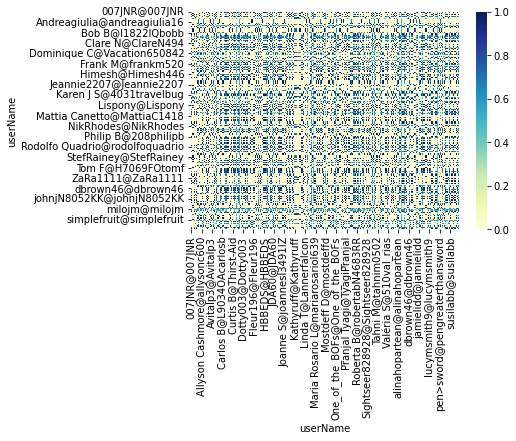

In [46]:
sns.heatmap(userName_userName_sim_matrix, cmap='YlGnBu')
plt.show()


In [47]:
# Check the matrix results
userName_userName_sim_matrix.head()

userName,007JNR@007JNR,0Garza@0Garza,101eggie@101eggie,1104@1104,110Helen2014@110Helen2014,110randn@110randn,1234texas@1234texas,13playaazul@13playaazul,1527holiday1011@1527holiday1011,157nk@157nk,...,zoeh198@zoeh198,zubenel57@zubenel57,zuni P@zunip,zylig@zylig,Ανδρόνικος Γκιουμές@T1025ZU_,Екатерина Г@_C5261QZ,Олександр П@X5628EZ_,Симеон Б@FrequentFlier415125,יוסי מ@K454TO_,桂子 大@_T2961PL
userName,,,,,,,,,,,,,,,,,,,,,
007JNR@007JNR,1.00000,0.57735,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.000000,0.00000,...,0.000000,0.00000,0.000000,0.00000,0.0,0.0,0.707107,0.00000,0.000000,1.00000
0Garza@0Garza,0.57735,1.00000,0.57735,0.57735,0.57735,0.0,0.0,0.57735,0.408248,0.57735,...,0.408248,0.57735,0.816497,0.57735,0.0,0.0,0.816497,0.57735,0.333333,0.57735
101eggie@101eggie,0.00000,0.57735,1.00000,0.00000,0.00000,0.0,0.0,0.00000,0.707107,0.00000,...,0.707107,1.00000,0.707107,0.00000,0.0,0.0,0.000000,1.00000,0.577350,0.00000
1104@1104,0.00000,0.57735,0.00000,1.00000,1.00000,0.0,0.0,1.00000,0.000000,1.00000,...,0.000000,0.00000,0.707107,1.00000,0.0,0.0,0.707107,0.00000,0.000000,0.00000
110Helen2014@110Helen2014,0.00000,0.57735,0.00000,1.00000,1.00000,0.0,0.0,1.00000,0.000000,1.00000,...,0.000000,0.00000,0.707107,1.00000,0.0,0.0,0.707107,0.00000,0.000000,0.00000


In [48]:
# Similar userNames
userName_userName_sim_matrix.loc['0Garza@0Garza'].sort_values(ascending=False)

userName
Ronald M@RonaldM548              1.0
cjdotheworld@cjdotheworld        1.0
Chelly & Art@ChellArtseeworld    1.0
B D@BD609                        1.0
AgedMan@AgedMan                  1.0
                                ... 
JB3@JohnBishop3                  0.0
asr224@asr224                    0.0
JAY@JIHAD40                      0.0
Daniel A@danielaI6579BU          0.0
Lily@Lilymack2                   0.0
Name: 0Garza@0Garza, Length: 3957, dtype: float64

In [50]:
# Check locals visited by tripType A
nonZeroLocals = (NameattuserNameMatrix.loc['0Garza@0Garza'] !=0)
userNameA_ranked_for_Nameatt = set(NameattuserNameMatrix.columns[nonZeroLocals])
userNameA_ranked_for_Nameatt

{'Mosteiro dos Jeronimos',
 'Park and National Palace of Pena',
 'Torre de Belém'}

In [51]:
# Check locals visited by tripType B
nonZeroLocals = (NameattuserNameMatrix.loc['zylig@zylig'] !=0)
userNameB_ranked_for_Nameatt = set(NameattuserNameMatrix.columns[nonZeroLocals])
userNameB_ranked_for_Nameatt

{'Mosteiro dos Jeronimos'}

In [52]:
# Local to recommend to tripType B
userNameB_ranked_for_Nameatt = userNameA_ranked_for_Nameatt - userNameB_ranked_for_Nameatt
userNameB_ranked_for_Nameatt

{'Park and National Palace of Pena', 'Torre de Belém'}

In [53]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5559 entries, 29827 to 89055
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   localID            5559 non-null   object        
 1   extractionDate     5559 non-null   datetime64[ns]
 2   globalRating       5559 non-null   float64       
 3   positionOnRanking  5559 non-null   int64         
 4   sitesOnRanking     5559 non-null   int64         
 5   totalReviews       5559 non-null   int64         
 6   userName           5559 non-null   object        
 7   userLocation       5559 non-null   object        
 8   userContributions  5559 non-null   int64         
 9   tripType           5559 non-null   object        
 10  reviewWritten      5559 non-null   datetime64[ns]
 11  reviewVisited      5559 non-null   datetime64[ns]
 12  reviewRating       5559 non-null   int64         
 13  reviewLanguage     5559 non-null   object        
 14  rev

## Based on tripType Similarity

In [54]:
# Similiar trioType matrix
Nameatt_Nameatt_sim_matrix = pd.DataFrame(
    pairwise_distances(NameattuserNameMatrix.T,metric='cosine'),
    columns = NameattuserNameMatrix.columns,
    index = NameattuserNameMatrix.columns
    )
Nameatt_Nameatt_sim_matrix = Nameatt_Nameatt_sim_matrix.apply(lambda x: 1-x, axis=1) # Transform dissimilarity to similarity
Nameatt_Nameatt_sim_matrix

Name,Bom Jesus do Monte,Cais da Ribeira,Mosteiro dos Jeronimos,Park and National Palace of Pena,Ponte de Dom Luís I,Quinta da Regaleira,Torre de Belém
Name,,,,,,,
Bom Jesus do Monte,1.000000,0.084545,0.031402,0.046452,0.068976,0.028705,0.036116
Cais da Ribeira,0.084545,1.000000,0.069234,0.066873,0.317380,0.037973,0.070072
Mosteiro dos Jeronimos,0.031402,0.069234,1.000000,0.165475,0.064712,0.103650,0.339378
Park and National Palace of Pena,0.046452,0.066873,0.165475,1.000000,0.057764,0.331217,0.151378
Ponte de Dom Luís I,0.068976,0.317380,0.064712,0.057764,1.000000,0.037210,0.071065
Quinta da Regaleira,0.028705,0.037973,0.103650,0.331217,0.037210,1.000000,0.104560
Torre de Belém,0.036116,0.070072,0.339378,0.151378,0.071065,0.104560,1.000000


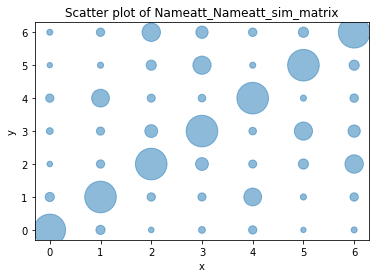

In [55]:
x = Nameatt_Nameatt_sim_matrix.columns
y = Nameatt_Nameatt_sim_matrix.index

x,y = np.meshgrid(range(Nameatt_Nameatt_sim_matrix.shape[1]), range(Nameatt_Nameatt_sim_matrix.shape[0]))
plt.scatter(x,y, s=Nameatt_Nameatt_sim_matrix.values*1000, alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter plot of Nameatt_Nameatt_sim_matrix')
plt.show()

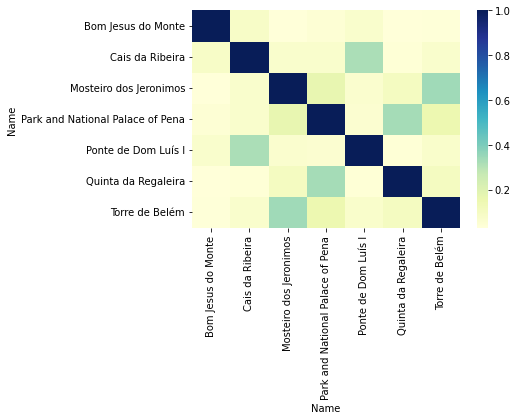

In [56]:
sns.heatmap(Nameatt_Nameatt_sim_matrix, cmap='YlGnBu')
plt.show()

In [57]:
# Top 3 attractions similar to 'Bom Jesus do Monte '
top_3_similar_attractions = list(
    Nameatt_Nameatt_sim_matrix
        .loc['Bom Jesus do Monte']
        .sort_values(ascending=False)
        .iloc[1:4]         # 1 to 4 instead of 0 to 10 because the first is the product itself
    .index
)
top_3_similar_attractions

['Cais da Ribeira', 'Ponte de Dom Luís I', 'Park and National Palace of Pena']